In [2]:
import ROOT as R

R.gStyle.SetOptStat(0)

Welcome to JupyROOT 6.20/06


In [1]:
inputfile = "/eos/user/d/dvalsecc/rdfexp/Remorphing/output_histos_topcr_gluonmorphed_quarkmorphed.root"
outputfile = "/eos/user/d/dvalsecc/rdfexp/Remorphing/morphing_qgl_gluon_quark_aftergluonandquarkmorph.root"

In [3]:
f = R.TFile(inputfile)

In [4]:
def get_cdf_func(h_i, name):
    h = h_i.Clone(name)
    h.Scale(1/h.Integral())
    h_cdf = h.GetCumulative()
    g_cdf = R.TGraph()
    g_inv = R.TGraph()
    g_cdf.SetName(name + '_cdf')
    g_inv.SetName(name + '_inv')
    g_cdf.SetBit(19)
    g_inv.SetBit(19)
    g_cdf.SetPoint(0, 0., 0.)
    g_inv.SetPoint(0, 0., 0.)
    for ibin in range(1, h_cdf.GetNbinsX()+1):
        #print(ibin,  h_cdf.GetBinCenter(ibin), h_cdf.GetBinContent(ibin))
        g_cdf.SetPoint(ibin, h_cdf.GetBinCenter(ibin), h_cdf.GetBinContent(ibin))
        g_inv.SetPoint(ibin, h_cdf.GetBinContent(ibin),h_cdf.GetBinCenter(ibin))
    g_cdf.SetPoint(ibin+1, 1., 1.)
    g_inv.SetPoint(ibin+1, 1., 1.)
    return g_cdf, g_inv


def get_morphing(gG, gT_inv, name):
    t = R.TGraph()
    t.SetName(name)
    for i,x in enumerate(np.linspace(0.,1.,200)):
        y = gT_inv.Eval(gG.Eval(x))
        t.SetPoint(i,x,y)
    return t

In [5]:
out = R.TFile(outputfile, "RECREATE")
morphs = {}
cdfs = {}
target_cdfs = {}

for j in ['vjet0', 'vjet1','vbs0','vbs1']:
    for i in [ "","_higheta","_loweta"] :
        jet = j+i
        hG = f.Get(jet + '_gluon')    
        hQ = f.Get(jet + '_quark') 
        hData = f.Get('DATA_'+ jet )
        hOthers = f.Get('Fake_'+ jet)

        nTot = hG.Integral() + hQ.Integral() + hOthers.Integral()
        # Scale data to tot MC
        hData.Scale(nTot / hData.Integral())

        hQ_target = hData.Clone("hQ_target_"+jet)
        hQ_target.Add(hOthers, -1.)
        hQ_target.Add(hG, -1.)

        gQ, gQ_inv= get_cdf_func(hQ, jet)
        gT , gT_inv = get_cdf_func(hQ_target, jet + "_target")
        morph = get_morphing(gQ, gT_inv, "quark_morphing_"+jet)
        morph.Write()
        morphs[jet] = morph
        cdfs[jet]= hQ
        target_cdfs[jet] = gT
        

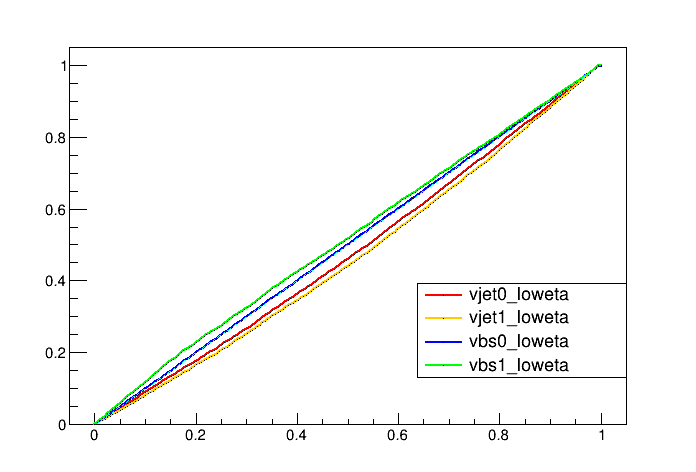

In [6]:
c = R.TCanvas()
leg = R.TLegend(0.6,0.2,0.9,0.4)
mg = R.TMultiGraph()
for i,(label, gr) in enumerate(morphs.items()):
    if "loweta" in label:
        mg.Add(gr)
        leg.AddEntry(gr, label)
        gr.SetLineWidth(2)
        if "vbs0" in label:  gr.SetLineColor(R.kBlue)
        if "vbs1" in label:  gr.SetLineColor(R.kGreen)
        if "vjet0" in label:  gr.SetLineColor(R.kRed)
        if "vjet1" in label:  gr.SetLineColor(R.kOrange)       

            
mg.Draw("APL")

fnc = R.TF1("a","x", 0, 1)
fnc.SetLineWidth(1)
fnc.SetLineStyle(2)
fnc.SetLineColor(R.kCyan)
fnc.Draw("same")
leg.Draw("same")
c.Draw()

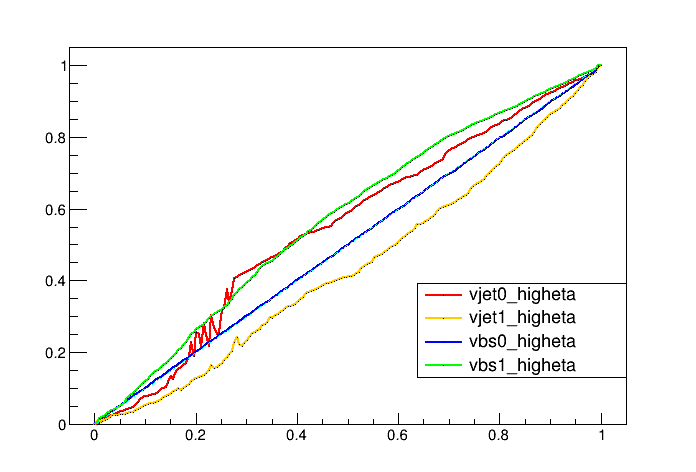

In [7]:
c = R.TCanvas()
leg = R.TLegend(0.6,0.2,0.9,0.4)
mg = R.TMultiGraph()
for i,(label, gr) in enumerate(morphs.items()):
    if "higheta" in label:
        mg.Add(gr)
        leg.AddEntry(gr, label)
        gr.SetLineWidth(2)
        if "vbs0" in label:  gr.SetLineColor(R.kBlue)
        if "vbs1" in label:  gr.SetLineColor(R.kGreen)
        if "vjet0" in label:  gr.SetLineColor(R.kRed)
        if "vjet1" in label:  gr.SetLineColor(R.kOrange)  

mg.Draw("APL")
fnc = R.TF1("a","x", 0, 1)
fnc.SetLineWidth(1)
fnc.SetLineStyle(2)
fnc.SetLineColor(R.kCyan)
fnc.Draw("same")
leg.Draw("same")
c.Draw()

# Purity check

In [4]:
fractions = {}

for j in ['vjet0', 'vjet1','vbs0','vbs1']:
    for i in [ "","_higheta","_loweta"] :
        jet = j+i
        hG = f.Get(jet + '_gluon')    
        hQ = f.Get(jet + '_quark') 
        hOthers = f.Get('Fake_'+ jet)

        nTot = hG.Integral() + hQ.Integral() + hOthers.Integral()
        fractions[jet] = [
            ["gluon","quark","others"],
            [100* hG.Integral()/ nTot, 100*hQ.Integral()/ nTot,100*hOthers.Integral()/ nTot,]
        ]
        print(jet)
        
        

vjet0
vjet0_higheta
vjet0_loweta
vjet1
vjet1_higheta
vjet1_loweta
vbs0
vbs0_higheta
vbs0_loweta
vbs1
vbs1_higheta
vbs1_loweta


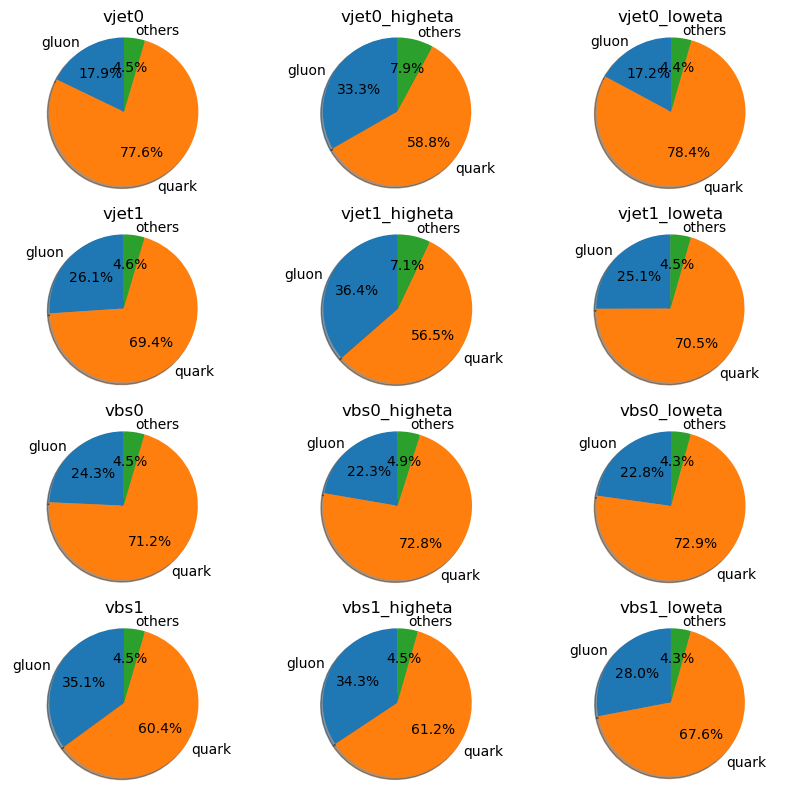

In [5]:
import matplotlib.pyplot as plt

fig1, axs = plt.subplots(4,3, figsize=(10,10), dpi=100)
for i,(jet,data) in enumerate(fractions.items()):
    
    row = i//3
    col = i%3
    axs[row,col].pie(data[1], labels=data[0], autopct='%1.1f%%',
            shadow=True, startangle=90)
    axs[row,col].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    axs[row,col].set_title(jet)
plt.show()
